## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [28]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import warnings
warnings.filterwarnings("ignore")

# 3. Metrics
from discriminative_score_metrics import discriminative_score_metrics
from predictive_score_metrics import predictive_score_metrics
from metric_utils import display_scores, visualization
import seaborn as sns

In [29]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def real_data_loading(data_name, seq_len):

    df = pd.read_csv(f'../datasets/{data_name}.csv', header=0)

    # Preprocess the data
    df = df.dropna()  # Handle missing values by dropping them
    data = df.values

    # Normalize the data (example: min-max normalization)
    scaler = MinMaxScaler()
    scaler.fit(data)
    normalized_data = scaler.transform(data)

    # Create sequences of length seq_len
    sequences = []
    for i in range(len(normalized_data) - seq_len + 1):
        sequences.append(normalized_data[i:i+seq_len])

    data = np.array(sequences)

    np.save(os.path.join('../generated_datasets/real_data_npy/', f"{data_name}.npy"), data)

    return data

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [30]:
## Data loading
data_name = 'ETTh2'
seq_len = 256
ori_data = real_data_loading(data_name, seq_len)
print(len(ori_data))

ckpt_name = f'model_{data_name}_generate_uncond_256'
#ckpt_name = f'ddpm_fake_{data_name}_256'
generated_data = np.load(f'../generated_datasets/{ckpt_name}.npy')[:len(ori_data), :, :]
ori_data = ori_data[:len(generated_data), :, :]
print(len(ori_data))
print(data_name + ' dataset is ready.')

17165
17165
ETTh2 dataset is ready.


## Evaluate the generated data

### 1. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

3.7.5


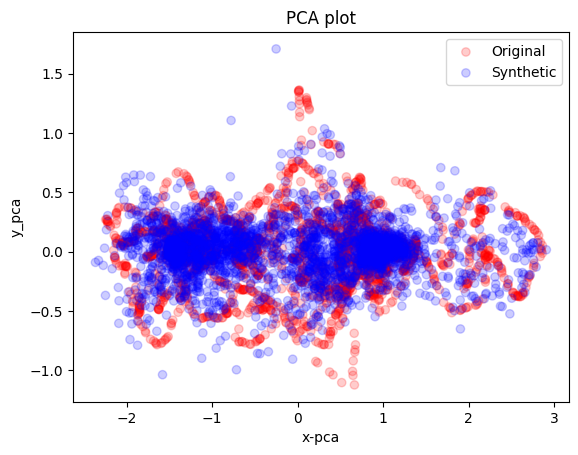

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.000s...
[t-SNE] Computed neighbors for 6000 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.158150
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.778290
[t-SNE] KL divergence after 300 iterations: 2.514580


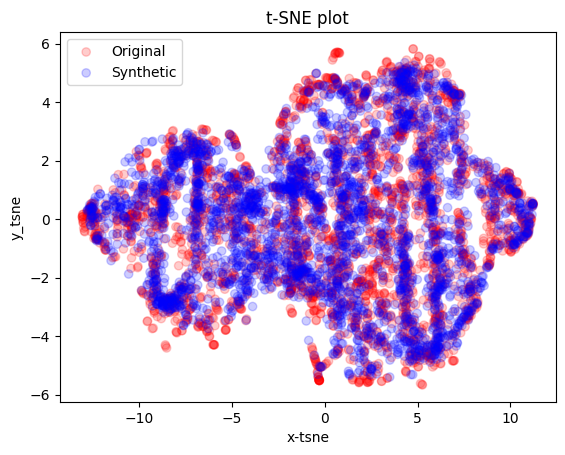

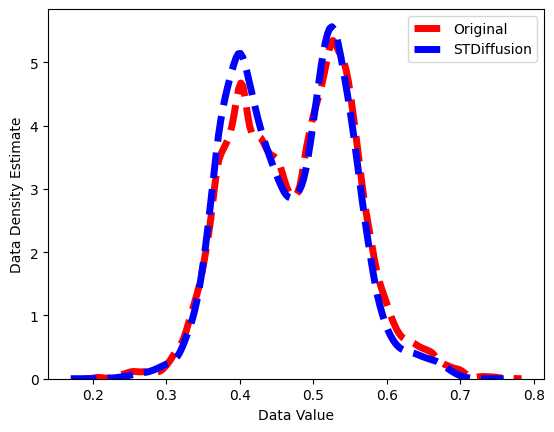

In [31]:
import matplotlib
print(matplotlib.__version__)
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')
visualization(ori_data, generated_data, 'kernel')

## Evaluate the generated data

### 2. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [32]:
metric_iteration = 5
discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc, fake_acc, real_acc = discriminative_score_metrics(ori_data, generated_data)
  print(f'fake acc: {fake_acc}, real acc: {real_acc}, dis_score: {temp_disc}')
  discriminative_score.append(temp_disc)

display_scores(discriminative_score)


training: 100%|██████████| 2000/2000 [03:06<00:00, 10.70it/s]


fake acc: 0.6227789105738422, real acc: 0.43344013981939994, dis_score: 0.02810952519662102


training: 100%|██████████| 2000/2000 [03:07<00:00, 10.69it/s]


fake acc: 0.6023885814156714, real acc: 0.471890474803379, dis_score: 0.037139528109525144


training: 100%|██████████| 2000/2000 [03:07<00:00, 10.69it/s]


fake acc: 0.7885231575881153, real acc: 0.3244975240314594, dis_score: 0.05651034080978734


training: 100%|██████████| 2000/2000 [03:06<00:00, 10.73it/s]


fake acc: 0.7544421788523158, real acc: 0.33498397902709, dis_score: 0.04471307893970289


training: 100%|██████████| 2000/2000 [03:06<00:00, 10.73it/s]

fake acc: 0.5525779201864258, real acc: 0.49927177395863676, dis_score: 0.025924847072531287
Final Score:  0.038479464025633535 ± 0.01559413248747908


## Evaluate the generated data

### 3. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [34]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  print(f'pred_score: {temp_pred}')
  predictive_score.append(temp_pred)   
    
# print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))
display_scores(predictive_score)

training: 100%|██████████| 5000/5000 [05:17<00:00, 15.73it/s]


pred_score: 0.10593653084724841


training: 100%|██████████| 5000/5000 [05:16<00:00, 15.78it/s]


pred_score: 0.1336139139109378


training: 100%|██████████| 5000/5000 [05:17<00:00, 15.73it/s]


pred_score: 0.10333891088441445


training: 100%|██████████| 5000/5000 [05:02<00:00, 16.54it/s]


pred_score: 0.09936215931363028


training: 100%|██████████| 5000/5000 [05:12<00:00, 16.00it/s]


pred_score: 0.09711164158791633
Final Score:  0.10787263130882944 ± 0.018365966841945518
